# Finding out how many traditional class formats are being offered in Fall 2021

As we find ourselves recovering from the pandemic and exiting quarantine, many schools are transitioning back to a traditional class format. For Rutgers - New Brunswick, the upcoming Fall semester is still in that transitionary period: many classes are hybrid or online only. Here, we'll look at just how many traditional classes are being offered across various departments.


If you've already got a handle on python and just want to see the code, go ahead and skip down to the last section. The code is all there.

## Required modules for retrieving and analyzing data

We'll need `requests` for retrieving data and formatting it in a way python can easily use it.
`pandas` and `matplotlib` are for analysis and data visualizing, though analysis might be too strong a word for what we're doing!
`Counter` is to help out with counting instances of each class format, while `time` is to help with rate limiting.

In [1]:
import json, requests
import pandas as pd, matplotlib.pyplot as plt
from collections import Counter
import time

## Retrieving data from Rutgers' Schedule of Classes

A sample url to access Rutgers' Schedule of Classes' data would look like this:

`https://sis.rutgers.edu/oldsoc/courses.json?subject=640&semester=92021&campus=NB&level=UG`

Importantly, the `640` refers to the department with subject code 640; in this case the mathematics department.
`92021` refers to Fall 2021, with `12021` referring to Spring 2021, and `02021` and `72021` referring to Winter and Summer respectively. We'll be retrieving our json data with this url.

In [2]:
url =  'https://sis.rutgers.edu/oldsoc/courses.json?subject=640&semester=92021&campus=NB&level=UG'
page = requests.get(url)

Remember to limit how frequently you retrieve the data. Using `time.sleep(2)` after each request will be more than sufficient. Any less than one request per second will be considered spam.

A first glance at our the first bit of our data:

In [3]:
page.content[:3000]

b'[{"subjectNotes":"MATHEMATICS INSTRUCTORS CANNOT ISSUE SPECIAL PERMISSION TO ENTER CLOSED COURSES. REQUESTS FOR SPECIAL PERMISSION MUST BE MADE BY APPLICATION TO THE MATHEMATICS DEPARTMENT.","courseNumber":"001","subject":"640","campusCode":"NB","openSections":1,"synopsisUrl":"https://math.rutgers.edu/academics/undergraduate/courses","subjectGroupNotes":null,"offeringUnitCode":"01","offeringUnitTitle":null,"title":"COMPUTATIONAL SKILLS","courseDescription":null,"preReqNotes":null,"sections":[{"sectionEligibility":null,"sessionDatePrintIndicator":"N","examCode":"B","specialPermissionAddCode":"03","crossListedSections":[],"sectionNotes":"BY PLACEMENTAUTOMATICALLY REGISTEREDFOR 640:025:14","specialPermissionDropCode":null,"instructors":[],"number":"14","majors":[],"sessionDates":null,"specialPermissionDropCodeDescription":null,"subtopic":null,"openStatus":true,"comments":[{"code":"56","description":"Online Course"},{"code":"05","description":"Go to http://canvas.rutgers.edu"}],"minors":

Pretty unreadable! Fortunately, we can use the `pprint` module to print this data out more pretty. 

In [4]:
from pprint import pprint
data = page.json()
pprint(data[0])

{'campusCode': 'NB',
 'coreCodes': [],
 'courseDescription': None,
 'courseNotes': None,
 'courseNumber': '001',
 'credits': 1.5,
 'expandedTitle': None,
 'offeringUnitCode': '01',
 'offeringUnitTitle': None,
 'openSections': 1,
 'preReqNotes': None,
 'sections': [{'campusCode': 'NB',
               'comments': [{'code': '56', 'description': 'Online Course'},
                            {'code': '05',
                             'description': 'Go to http://canvas.rutgers.edu'}],
               'crossListedSections': [],
               'examCode': 'B',
               'honorPrograms': [],
               'index': '15264',
               'instructors': [],
               'legendKey': None,
               'majors': [],
               'meetingTimes': [{'baClassHours': None,
                                 'buildingCode': None,
                                 'campusAbbrev': '**',
                                 'campusLocation': 'O',
                                 'campusName': '** IN

The data is structured around each course the department is offering. However, we want to look at course sections. To access that data, we'll need to look at the `sections` of a given course. For example, for 640:001's courses:


In [5]:
data[0]['sections']

[{'sectionEligibility': None,
  'sessionDatePrintIndicator': 'N',
  'examCode': 'B',
  'specialPermissionAddCode': '03',
  'crossListedSections': [],
  'sectionNotes': 'BY PLACEMENTAUTOMATICALLY REGISTEREDFOR 640:025:14',
  'specialPermissionDropCode': None,
  'instructors': [],
  'number': '14',
  'majors': [],
  'sessionDates': None,
  'specialPermissionDropCodeDescription': None,
  'subtopic': None,
  'openStatus': True,
  'comments': [{'code': '56', 'description': 'Online Course'},
   {'code': '05', 'description': 'Go to http://canvas.rutgers.edu'}],
  'minors': [],
  'campusCode': 'NB',
  'index': '15264',
  'unitMajors': [],
  'printed': 'Y',
  'specialPermissionAddCodeDescription': 'Department staff',
  'subtitle': None,
  'meetingTimes': [{'campusLocation': 'O',
    'baClassHours': None,
    'roomNumber': None,
    'pmCode': 'A',
    'campusAbbrev': '**',
    'campusName': '** INVALID **',
    'meetingDay': 'T',
    'buildingCode': None,
    'startTime': '0900',
    'endTime': 

There's a lot of useful information here! For our purposes, we're interested in the meeting times. Specifically, the `campusLocation` will give us the information we need. For instance, we can see this section has a campus location of `O`. This means that the class is online. Other possible values are `1`, `2`, `3`, `4`, and `other`. The numbers refer to College Ave, Busch, Livingston, and Cook/Doug respectively, while `other` refers to classes like independent studies, internships, or thesis classes, where meetings are determined by students and instructors. We're finally getting close to the analysis we want!

## Storing Data Cleanly

It's good practice to store the data we want in some kind of chart or array. We'll be using `pandas`' dataframes, but there are other options out there.
A dataframe is in many ways similar to an excel spreadsheet. In fact, you can very easily export dataframes to excel. First, we'll want to create an empty dataframe, and then add our data row by row.

In [6]:
df = pd.DataFrame(columns = ['subject', 'courseNumber', 'index', 'campusCode'])
df.head()

,subject,courseNumber,index,campusCode


Something important to note is that a course can meet up in different campuses or can be a hybrid course. For example, lectures can be on one campus while recitations are on another. We'll be saving all that data in the `campusCode` column as a list of campus locations.

We'll also be saving the campus locations numerically. Recall that College Ave, Busch, Livi, and Cook/Doug were already represented with numbers. We'll convert `O` to `0`, and `other` to `5`. This will help out with determining if a class is hybrid or not, as we'll see below.

In order to do so, we'll define a helper function:

In [7]:
def helperconvert(s):
    try:
        return int(s)
    except:
        if s == 'O':
            return 0
        else:
            return 5

Now to add the rows in the dataframe.

Side note: we use a list comprehension to help us with generating the `campusCode` column. If you're shaky on how to read or use them, check out [w3's tutorial on them.](https://www.w3schools.com/python/python_lists_comprehension.asp)

In [8]:
for course in data:
    for section in course['sections']:
        df = df.append({'subject': int(course['subject']), 
                        'courseNumber' : int(course['courseNumber']), 
                        'index': int(section['index']),  
                        'campusCode' : [helperconvert(meeting['campusLocation']) for meeting in section['meetingTimes']]}, 
                       ignore_index=True)
df.head(10)

,subject,courseNumber,index,campusCode
0,640,1,15264,[0]
1,640,5,3499,[5]
2,640,11,3500,[2]
3,640,12,3502,[2]
4,640,13,3504,[2]
5,640,25,15266,"[0, 0]"
6,640,25,15267,"[0, 0]"
7,640,25,15268,"[0, 0]"
8,640,25,15269,"[4, 0]"
9,640,25,15270,"[0, 4]"


Great! We've got our data in a tidy dataframe, and can perform further calculations with it. Right now, we'll want to add another column that tells us the class format, based on the `campusCode`.

With how we set up our column, this is easy enough to calculate. If there's a `0` in the list, then the class must be either online or hybrid. If there's also a number other than `0`, then its a hybrid. Otherwise, if there's a `5` in the list, then the class is some other kind of class, not traditional, hybrid, or online. In all other cases, the class is traditional.

Writing out this logic as a function, we get the following:



In [9]:
def helperhybridornot(row):
    if 0 in row['campusCode']:
        if sum(row['campusCode']) == 0:
            return 'online'
        else:
            return 'hybrid'
    if 5 in row['campusCode']:
        return 'other'
    else:
        return 'traditional'

Adding a new column to our dataframe is as simple as applying our function to each row of `campusCode`, and saving the result in the new column, which we'll call `classType`. To do so, we'll need to create a lambda function which has an input of our row, and outputs the classtype.

In [10]:
df['classType'] = df.apply (lambda row : helperhybridornot(row), axis = 1)

In [11]:
df.head(10)

,subject,courseNumber,index,campusCode,classType
0,640,1,15264,[0],online
1,640,5,3499,[5],other
2,640,11,3500,[2],traditional
3,640,12,3502,[2],traditional
4,640,13,3504,[2],traditional
5,640,25,15266,"[0, 0]",online
6,640,25,15267,"[0, 0]",online
7,640,25,15268,"[0, 0]",online
8,640,25,15269,"[4, 0]",hybrid
9,640,25,15270,"[0, 4]",hybrid


## Visualizing the Data

Now for the final step: visualizing the data. A pie chart is a great way to visualize this data, but there are other options. We'll need `Counter` to count how many instances of each class type show up, and `matplotlib` for creating the pie charts.

In [12]:
c = Counter(df['classType'])
label, quant = c.keys(), c.values()

print(c)
print(label)
print(quant)

Counter({'hybrid': 264, 'online': 97, 'traditional': 32, 'other': 3})
dict_keys(['online', 'other', 'traditional', 'hybrid'])
dict_values([97, 3, 32, 264])


The `Counter` function creates a dictionary, or key-value pairs, of the class type and how frequently it appears in the columns. We'll want to save the labels and the quantities as lists, which is what the `.keys()` and `.values()` methods do.

Finally, the pie chart! 
Using (matplotlib's documentation)[https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html], we can create the pie chart exactly how we want it to look. I encourage you to mess around with the parameters and create a pie chart that you like the look of.

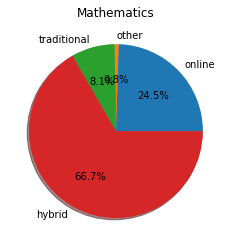

In [13]:
fig, ax = plt.subplots() 
    
ax.pie(quant,                  ## The numerical quantities that we counted
    labels = label,         ## The labels (hybrid, tradtional, online, other)
    shadow = True,          ## Whether or not there's a shadow
    autopct='%1.1f%%')      ## How many decimals the percentage goes.
    
ax.set(title = 'Mathematics')
plt.show()

We're done! As we can see, the math department is offering very few traditional classes, but a lot of hybrid classes. Not too bad, but definitely not representative of all the departments. As can be seen in the charts I created down below, each department is very different in its offerings. Its a great time to be an Economics major, but not so much an ECE major. Try out some other departments to get a better picture of what Rutgers-NB campus will look like next fall!

## Code

In [14]:
## retrieves and returns SOC data as json/python list

def getdata(url):
    page = requests.get(url)
    data = page.json()
    return data


In [15]:
## converts class meeting place to numerical data

def helperconvert(s):
    try:
        return int(s)
    except:
        if s == 'O':
            return 0
        return 5

In [16]:
## determines if a class is hybrid or not
def helperhybridornot(row):
    if 0 in row['campusCode']:
        if sum(row['campusCode']) == 0: ## sum == 0 iff all meetings are online. 
            return 'online'
        else:
            return 'hybrid'
    if 5 in row['campusCode']:
        return 'other'
    return 'traditional'

In [17]:
## creates df

def createdf(data):
    df = pd.DataFrame(columns =  ['subject', 'courseNumber', 'index', 'campusCode'])
    for course in data:
        for section in course['sections']:
            df = df.append({'subject': int(course['subject']), 
                            'courseNumber' : int(course['courseNumber']), 
                            'index': int(section['index']),  
                            'campusCode' : [helperconvert(meeting['campusLocation']) for meeting in section['meetingTimes']]}, 
                           ignore_index=True)
            df['classType'] = df.apply (lambda row : helperhybridornot(row), axis = 1)
    return df

In [18]:
def pieplot(df, name):
    c = Counter(df['classType'])
    label, quant = c.keys(), c.values()
    fig, ax = plt.subplots() 
    
    ax.pie(quant, labels = label, shadow = True, autopct='%1.1f%%')
    ax.set(title = name)
    plt.savefig(f'{name}.jpeg', transparent = False)
    plt.show()

In [19]:
## sample departments

deptno = ['730', '220', '185', '640', '198' , '615', '840', '960', '540', '635', '506', '332', '160', '420',  '082', '790', '750', '070', '375']
deptname = ['Philosophy', 'Economics', 'Cognitive Science', 'Math' ,'Computer Science', 'Linguistics', 'Religion', 'Statistics', 'ISE', 'Material Sciences', 'History', 'ECE', 'Chemistry', 'French', 'Art History', 'Political Science', 'Physics', 'Anthropology', 'Envi Sci']

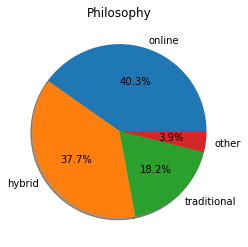

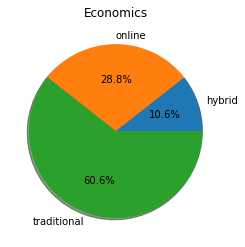

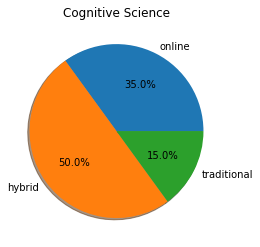

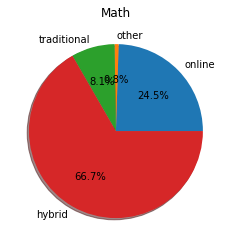

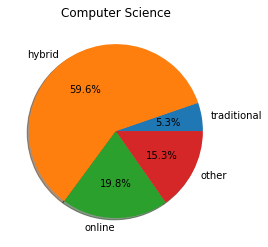

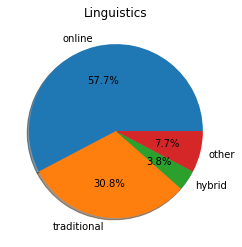

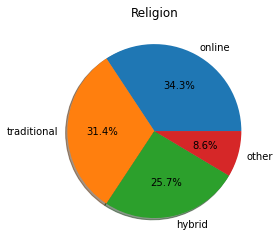

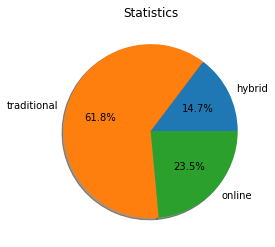

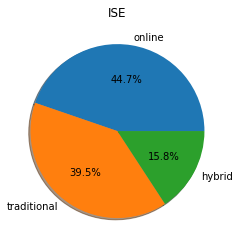

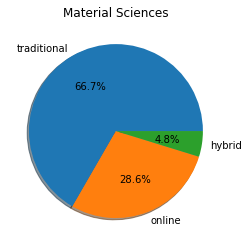

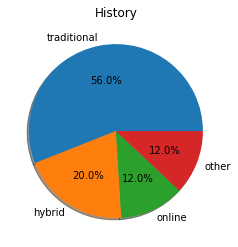

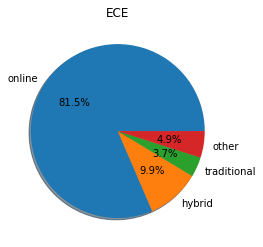

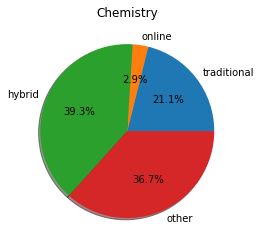

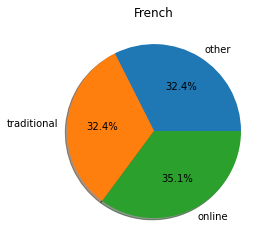

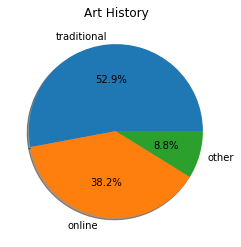

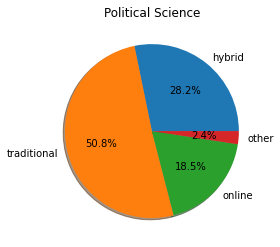

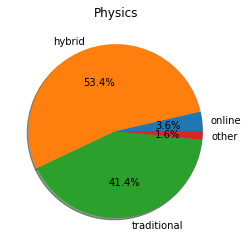

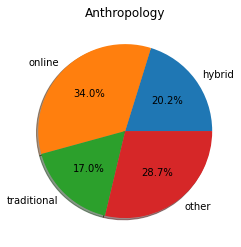

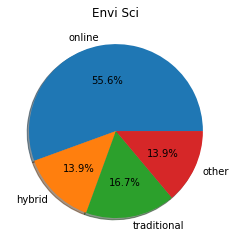

In [22]:
for d in range(len(deptno)):
    pieplot(createdf(getdata(f'https://sis.rutgers.edu/oldsoc/courses.json?subject={deptno[d]}&semester=92021&campus=NB&level=UG')), deptname[d])
    time.sleep(5)